# Bloch Simulator Quickstart

Run the simulator without the GUI. Adjust flip angle, pulse duration, frequencies, and positions from the cells below.

In [1]:
import numpy as np
from bloch_simulator import BlochSimulator, TissueParameters, design_rf_pulse

# Helper to build frequency and position arrays
def build_frequencies(nfreq=1, span_hz=0.0, explicit=None):
    if explicit is not None:
        return np.array(explicit, dtype=float)
    if nfreq <= 1:
        return np.array([0.0])
    span = span_hz if span_hz > 0 else max(1.0, nfreq - 1)
    return np.linspace(-span / 2.0, span / 2.0, nfreq)

def build_positions(npos=1, span_cm=0.0):
    if npos <= 1:
        return np.array([[0.0, 0.0, 0.0]])
    span_m = span_cm / 100.0
    xs = np.linspace(-span_m / 2.0, span_m / 2.0, npos)
    pos = np.zeros((npos, 3))
    pos[:, 0] = xs
    return pos


In [44]:
# Configure the simulation parameters here
flip_angle = 90.0            # degrees
pulse_duration_ms = 1.0     # ms
nfreq = 3                   # number of frequencies
freq_span_hz = 1000.0        # symmetric span around 0 (ignored if freqs_explicit set)
freqs_explicit = None       # e.g., [-50, 0, 50] to override nfreq/span
npos = 11                   # number of positions along x
pos_span_cm = 10.0           # span along x in cm
t1 = 1.0                    # seconds
    
t2 = 0.1                    # seconds
mode_time_resolved = True   # True => time-resolved (mode 2), False => endpoint (mode 0)
use_parallel = False


Simulation complete
RF points: 200, dt ~ 5.000 us, duration: 1.000 ms
Positions: (11, 3), Frequencies: [-500.    0.  500.]


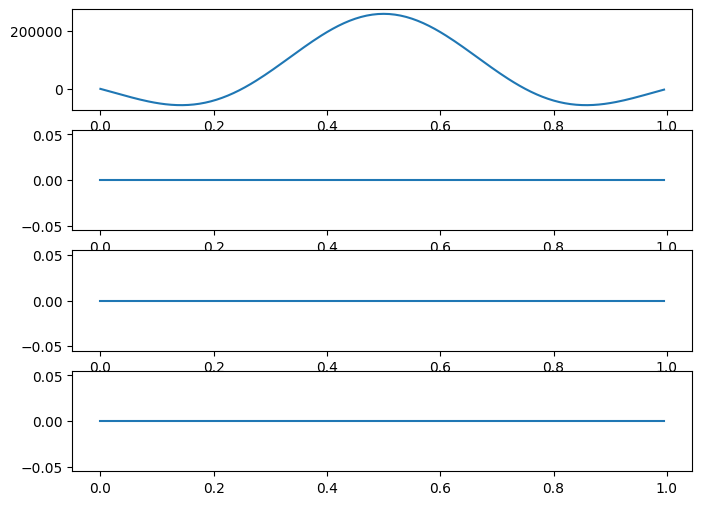

In [45]:
# Build RF pulse
duration_s = pulse_duration_ms / 1000.0
npoints = max(8, int(np.ceil(duration_s / 5e-6)))
b1, time = design_rf_pulse('sinc', duration=duration_s, flip_angle=flip_angle, npoints=npoints)
gradients = np.zeros((len(time), 3))

import matplotlib.pyplot as plt
fig, ax = plt.subplots(4, 1, figsize=(8, 6))
ax[0].plot(time*1e3, np.real(b1)*1e6)
ax[1].plot(time*1e3, gradients[:,0])
ax[2].plot(time*1e3, gradients[:,1])
ax[3].plot(time*1e3, gradients[:,2])

gradients[:, 0] = 0.5



frequencies = build_frequencies(nfreq=nfreq, span_hz=freq_span_hz, explicit=freqs_explicit)
positions = build_positions(npos=npos, span_cm=pos_span_cm)
mode = 2 if mode_time_resolved else 0

tissue = TissueParameters(name='Notebook', t1=t1, t2=t2)
sim = BlochSimulator(use_parallel=use_parallel)

result = sim.simulate((b1, gradients, time), tissue, positions=positions, frequencies=frequencies, mode=mode)

print('Simulation complete')
print(f'RF points: {len(b1)}, dt ~ {np.mean(np.diff(time))*1e6:.3f} us, duration: {duration_s*1e3:.3f} ms')
print(f'Positions: {positions.shape}, Frequencies: {frequencies}')


In [46]:
positions

array([[-0.05,  0.  ,  0.  ],
       [-0.04,  0.  ,  0.  ],
       [-0.03,  0.  ,  0.  ],
       [-0.02,  0.  ,  0.  ],
       [-0.01,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ],
       [ 0.01,  0.  ,  0.  ],
       [ 0.02,  0.  ,  0.  ],
       [ 0.03,  0.  ,  0.  ],
       [ 0.04,  0.  ,  0.  ],
       [ 0.05,  0.  ,  0.  ]])

In [39]:
result.keys()

dict_keys(['mx', 'my', 'mz', 'signal', 'time', 'positions', 'frequencies', 'tissue'])

In [41]:
print(result['mx'].shape)
print(positions.shape)

(200, 31, 3)
(31, 3)


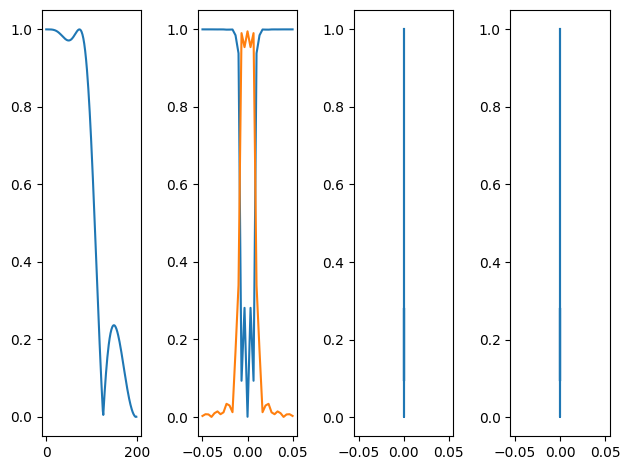

In [42]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,4)
ax[0].plot(np.abs(np.squeeze(result['mz'][:,npos//2,nfreq//2])))
ax[1].plot(positions[:,0], np.abs(np.squeeze(result['mz'][-1,:,nfreq//2])))
ax[1].plot(positions[:,0], np.abs(np.squeeze(result['signal'][-1,:,nfreq//2])))
ax[2].plot(positions[:,1], np.abs(np.squeeze(result['mz'][-1,:,nfreq//2])))
ax[3].plot(positions[:,2], np.abs(np.squeeze(result['mz'][-1,:,nfreq//2])))

plt.tight_layout()


In [ ]:
# Inspect final magnetization per position/frequency
if mode == 0:
    mx_final = result['mx']
    my_final = result['my']
    mz_final = result['mz']
else:
    mx_final = result['mx'][-1]
    my_final = result['my'][-1]
    mz_final = result['mz'][-1]

print('Final magnetization (per position x frequency):')
for pi in range(mx_final.shape[0]):
    for fi in range(mx_final.shape[1]):
        mxy = np.sqrt(mx_final[pi, fi]**2 + my_final[pi, fi]**2)
        print(f'  pos {pi:02d}, freq {fi:02d}: mx={mx_final[pi,fi]: .4f}, my={my_final[pi,fi]: .4f}, mz={mz_final[pi,fi]: .4f}, |Mxy|={mxy: .4f}')
